<a href="https://colab.research.google.com/github/plaban1981/Pytorch_lightning/blob/main/Copy_of_Kaggle_Predict_the_Severity_Grading_of_Knee_Osteoarthritis_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

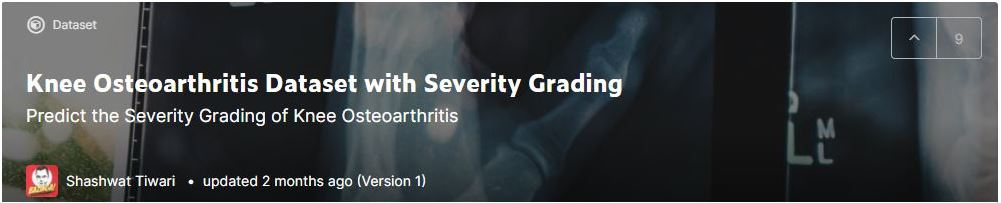

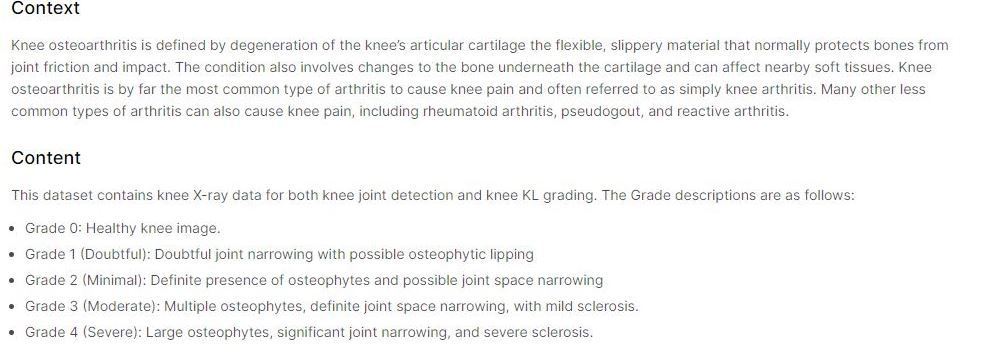

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Import Required Libaries

In [ ]:
%%capture 
!pip install pytorch-lightning

In [ ]:
%%capture
!pip install timm

In [ ]:
import torch
import pytorch_lightning as pl
print(torch.__version__)
print(pl.__version__)

1.8.1+cu101
1.3.4


In [ ]:
import os
import shutil
#import albumentations
#from albumentations.pytorch import ToTensorV2
#
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import *
#
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.optimizer import Optimizer
from torchvision import models, transforms
from torch.utils.data import TensorDataset,Dataset,DataLoader
#
import cv2
from PIL import Image
from PIL import ImageFilter
from google.colab.patches import cv2_imshow
#
import matplotlib.pyplot as plt
import seaborn as sns
#
import pytorch_lightning as pl
from pytorch_lightning import metrics
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from pytorch_lightning.callbacks.finetuning import BaseFinetuning
from pytorch_lightning.utilities import rank_zero_info
#
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CometLogger
# 
import warnings
warnings.filterwarnings('ignore')

## Function to Preprocess Images

In [ ]:
def preProcess_Image(image):
  img = cv2.imread(image)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
  img = cv2.equalizeHist(img[:, :, 0])
  #img = cv2.Canny(img, 80, 100)
  #kernel = np.ones((5, 5), np.uint8)
  #img = cv2.erode(img, kernel, iterations=3)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Function to display images

In [ ]:
def show_image(image,label):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))
  orig_img = cv2.imread(image)
  orig_img = cv2.resize(orig_img, (224, 224))
  processed_img =  preProcess_Image(image)
  ax1.imshow(orig_img)
  ax2.imshow(processed_img)
  ax1.set_title(f'Original Image {label}')
  ax2.set_title(f'Processed Image {label}')

In [ ]:
Root = "/content/drive/MyDrive/Knee"
folders = ['auto_test', 'test', 'train', 'val']
print(folders)

['auto_test', 'test', 'train', 'val']


## Combine all the images from train test and validation folders into a single image and folder list and create a dataframe

In [ ]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "/content/drive/MyDrive/Knee/"

# list of folders
folder_list = folders
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})
df_train_kaggle.shape

(9786, 2)

In [ ]:
df_train_kaggle.head()

,filepath,label
0,/content/drive/MyDrive/Knee/auto_test/0/906216...,0
1,/content/drive/MyDrive/Knee/auto_test/0/904346...,0
2,/content/drive/MyDrive/Knee/auto_test/0/900418...,0
3,/content/drive/MyDrive/Knee/auto_test/0/902440...,0
4,/content/drive/MyDrive/Knee/auto_test/0/902393...,0


## Visualize Training Images

In [ ]:
file_paths = df_train_kaggle.filepath.values.tolist()
labels = df_train_kaggle.label.values.tolist()

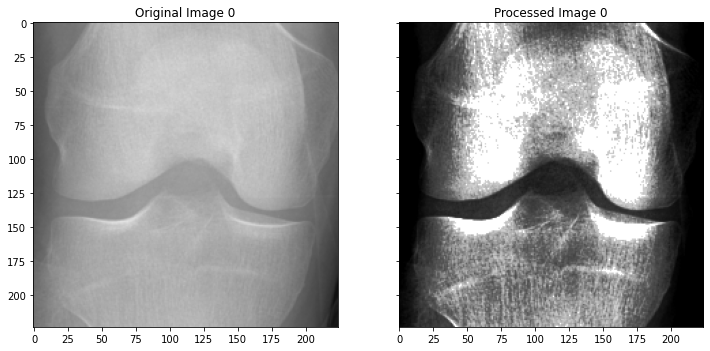

In [ ]:
i = np.random.randint(0,100)
show_image(file_paths[i],labels[i])

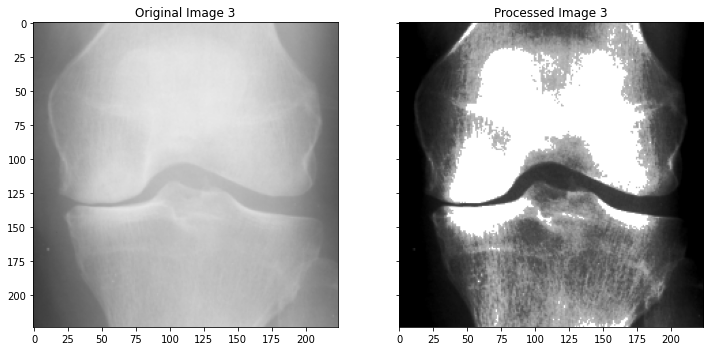

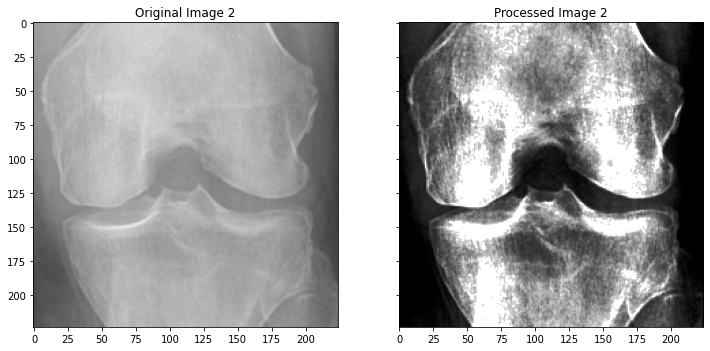

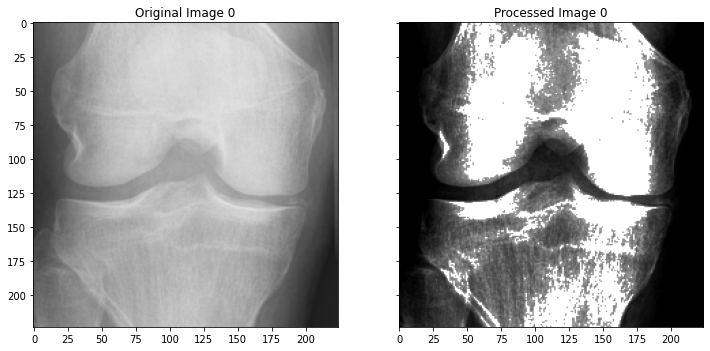

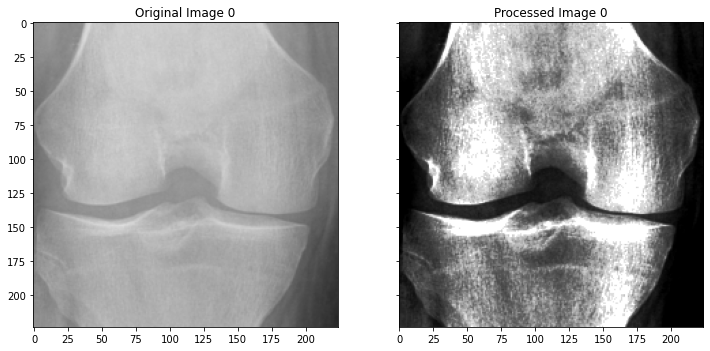

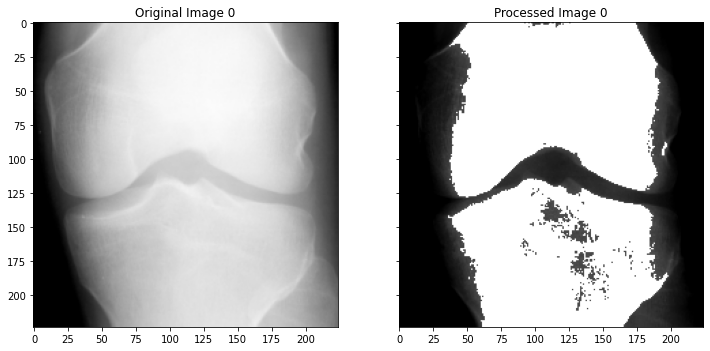

In [ ]:
for i in range(5):
  i = np.random.randint(1000,2000)
  show_image(file_paths[i],labels[i])

## Determine Image Shape

In [ ]:
preProcess_Image(file_paths[i]).shape

(224, 224, 3)

## Download actual Competition data and treat it as validation data initially

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC',
                                    dest_path='content/KneeXray.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
valid_df = pd.read_csv("/content/content/KneeXray/Train.csv")
valid_df.head()

,filename,label
0,Image_1.jpg,0
1,Image_2.jpg,1
2,Image_3.jpg,0
3,Image_4.jpg,1
4,Image_5.jpg,2


## Visualize Labels

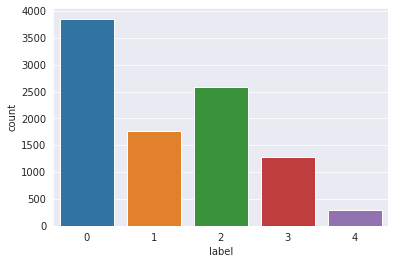

In [ ]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=df_train_kaggle)
plt.show()

## Stratified Kfold

In [ ]:
dfx = df_train_kaggle.copy()
dfx["kfold"] = -1

dfx = dfx.sample(frac=1).reset_index(drop=True)

kf = StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=dfx, y=dfx.label.values)):
    print(len(trn_), len(val_))
    dfx.loc[val_, 'kfold'] = fold

7828 1958
7829 1957
7829 1957
7829 1957
7829 1957


In [ ]:
dfx.head()

,filepath,label,kfold
0,/content/drive/MyDrive/Knee/train/0/9624154R.png,0,0
1,/content/drive/MyDrive/Knee/test/0/9509846R.png,0,0
2,/content/drive/MyDrive/Knee/train/1/9413676L.png,1,0
3,/content/drive/MyDrive/Knee/auto_test/0/937636...,0,0
4,/content/drive/MyDrive/Knee/train/0/9782690R.png,0,0


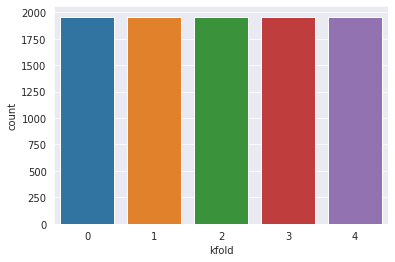

In [ ]:
sns.set_style('darkgrid')
sns.countplot(x='kfold',data=dfx)
plt.show()

In [ ]:
dfx.to_csv(os.path.join(Root,"train_set_folds.csv"), index = False)